In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from agents.ucb_like.cusum import CUSUMUCBAgent
from agents.ucb_like.gp_ucb import GPUCBAgent
from agents.ucb_like.sliding_window import SWUCBAgent
from environments.non_stationary import NonStationaryPricingEnv
from environments.multi_product import MultiProductPricingEnv
from utils.rbf_gaussian_process import RBFGaussianProcess

## Non-stationary pricing environment

### Parameter definition

In [3]:
# Utility function
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

In [4]:
# Parameters definition
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)

T = 10000 # number of rounds
daily_customers = 100

K = 100 # discretization intervals

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

In [5]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-p/max_price,  # linear demand curve
]

In [21]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1-np.exp(-p/max_price),  # exponential demand curve
    lambda p: 1/(1+np.exp(-p/max_price)),  # logistic demand curve
    lambda p: 1 / (1 + np.log(p - min_price + 1)),  # logarithmic demand curve
    lambda p: 1 / (1 + np.sqrt(p - min_price)),  # square root demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 2)),  # square demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 3)),  # cubic demand curve
    lambda p: 1 / (1 + np.exp(0.1 * (p - (max_price + min_price) / 2))),  # sigmoid demand curve
    lambda p: min_price / p,  # inverse demand curve
    lambda p: np.sin(p/max_price)  # sine demand curve
]

In [19]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    lambda p: 1 / (1 + np.log(p - min_price + 1)),  # logarithmic demand curve
    lambda p: 1 / (1 + np.sqrt(p - min_price)),  # square root demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 2)),  # square demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 3)),  # cubic demand curve
]

In [22]:
mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()
len(mu)

10000

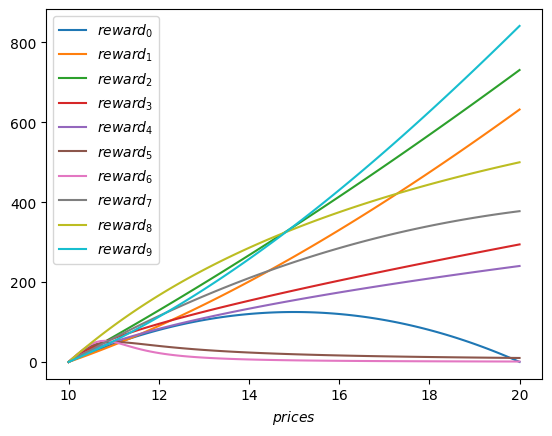

In [17]:
profit_curves_per_price = []
for p in prices:
    prob_per_price = []
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        prob_per_price.append(reward_function(p, cost, daily_customers * conv_prob(p)))
    profit_curves_per_price.append(prob_per_price)

plt.plot(prices, profit_curves_per_price, label=[f'$reward_{i}$' for i in range(len(conversion_probabilities))])
plt.legend()
plt.xlabel('$prices$')
plt.show();

In [18]:
# let's compute the clairvoyant
# Each interval has a different conversion probability function and i calculate the best price for each interval
# The clayrvoiant will choose the best price for each interval and will sell to all the customers in the interval
best_prices = np.array([])
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    conv_prob = mu[t]
    daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
    best_price_index = np.argmax(daily_profit_curve)
    best_price = prices[best_price_index]
    best_prices = np.append(best_prices, best_price)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_profit_curve[best_price_index])


100%|██████████| 10000/10000 [00:00<00:00, 39603.80it/s]


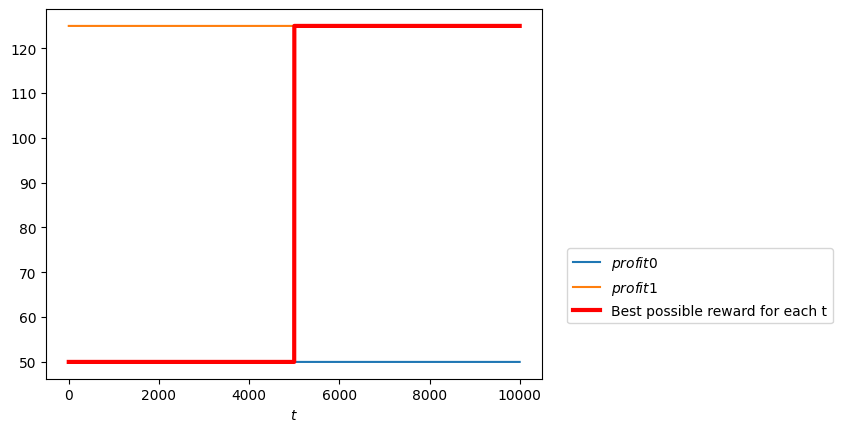

In [11]:
profits = []
for i in range(len(conversion_probabilities)):
    profit_per_prob = np.array([])
    conv_prob = conversion_probabilities[i]
    for t in tqdm(range(T)):
        daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
        best_price_index = np.argmax(daily_profit_curve)
        profit_per_prob = np.append(profit_per_prob, daily_profit_curve[best_price_index])
    profits.append(profit_per_prob)

t = np.arange(T)
for i in range(len(conversion_probabilities)):
    plt.plot(t, profits[i], label=f'$profit{i}$')
plt.plot(t, expected_clairvoyant_rewards, label='Best possible reward for each t', linewidth=3, color='red')
plt.legend(loc=(1.05,0.15))
plt.xlabel('$t$')
plt.show();

### Sliding Window UCB1

In [12]:
K = len(prices) # number of arms
U = len(conversion_probabilities) # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U)) # assuming U_T is known
W = 2000
print(f'K={K}, U={U}, W={W}')

n_trials = 2

mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()

regret_per_trial = []

for seed in tqdm(range(n_trials)):

    np.random.seed(seed)

    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = SWUCBAgent(K, T, W, range=max(expected_clairvoyant_rewards)
)

    agent_rewards = np.array([])
    chosen_prices = np.array([])
    for t in tqdm(range(T)):
        i = ucb_agent.pull_arm()
        p_t = prices[i]
        chosen_prices = np.append(chosen_prices, p_t)
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

K=100, U=2, W=2000


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:46<00:00, 23.07s/it]


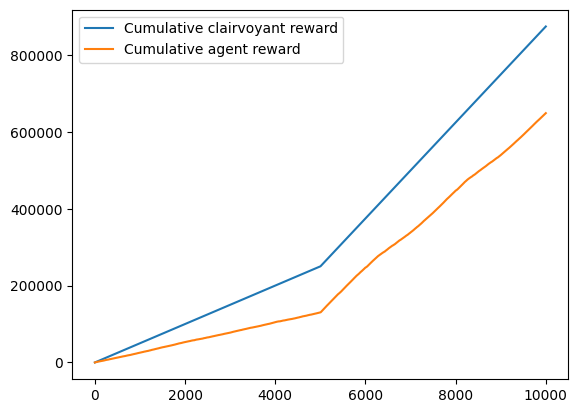

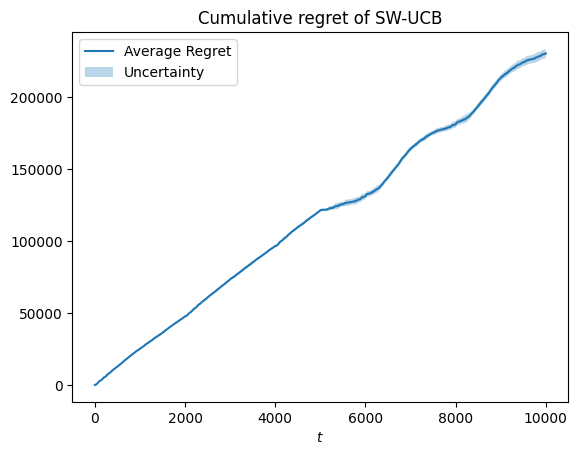

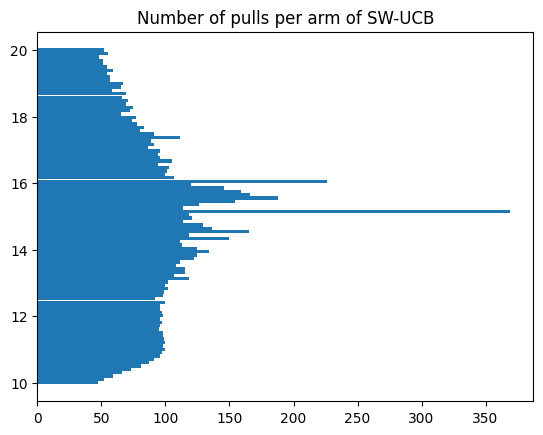

In [17]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.legend()
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.1)
plt.title('Number of pulls per arm of SW-UCB')
plt.show();

### CUSUM

In [18]:
K = len(prices)
U = len(conversion_probabilities) # maximum number of abrupt changes
h = 5*max(expected_clairvoyant_rewards)*np.log(T/U) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U*np.log(T/U)/T) # probability of extra exploration
M = int(2*np.log(T/U)) # robustness of change detection

n_trials = 5

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha, range=max(expected_clairvoyant_rewards))

    agent_rewards = np.array([])

    for t in tqdm(range(T)):
        a_t = ucb_agent.pull_arm()
        p_t = prices[a_t]
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

 52%|█████▏    | 5248/10000 [00:00<00:00, 6018.32it/s] 

Change detected on arm 63 at time 5052


 50%|████▉     | 4990/10000 [00:00<00:00, 7245.19it/s] 

Change detected on arm 52 at time 5052


 58%|█████▊    | 5754/10000 [00:00<00:00, 4904.81it/s]

Change detected on arm 52 at time 5689


 92%|█████████▏| 9211/10000 [00:06<00:00, 1277.69it/s]

Change detected on arm 52 at time 8790


 53%|█████▎    | 5257/10000 [00:00<00:00, 6063.79it/s] 

Change detected on arm 71 at time 5067


 92%|█████████▏| 9218/10000 [00:10<00:00, 1188.81it/s]

Change detected on arm 71 at time 8867


 57%|█████▋    | 5656/10000 [00:00<00:00, 4488.97it/s] 

Change detected on arm 16 at time 5256


 65%|██████▌   | 6509/10000 [00:01<00:01, 2846.78it/s]

Change detected on arm 64 at time 6064


 97%|█████████▋| 9656/10000 [00:07<00:00, 1414.26it/s]

Change detected on arm 64 at time 9130


 56%|█████▌    | 5595/10000 [00:00<00:00, 5767.54it/s] 

Change detected on arm 16 at time 5246


 67%|██████▋   | 6682/10000 [00:01<00:00, 3389.04it/s]

Change detected on arm 77 at time 6135
Change detected on arm 77 at time 6687


 83%|████████▎ | 8251/10000 [00:02<00:00, 1775.12it/s]

Change detected on arm 77 at time 7917


 88%|████████▊ | 8758/10000 [00:02<00:00, 1946.24it/s]

Change detected on arm 77 at time 8454


 95%|█████████▍| 9493/10000 [00:02<00:00, 2174.15it/s]

Change detected on arm 77 at time 9047


100%|██████████| 10000/10000 [00:03<00:00, 2911.83it/s]


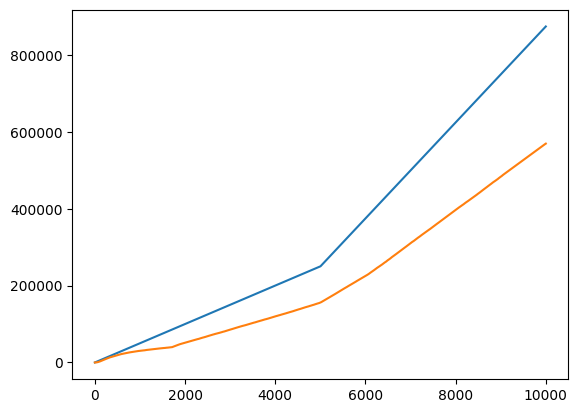

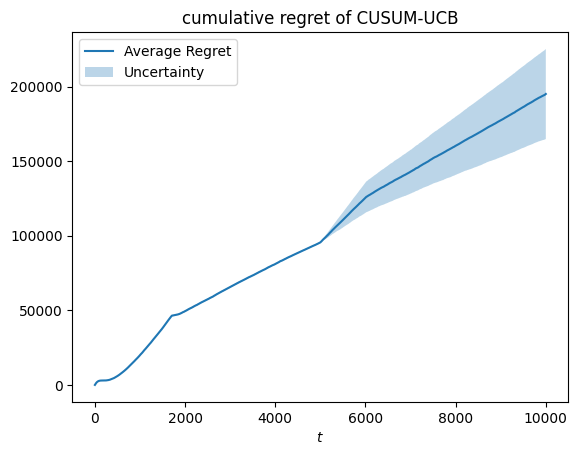

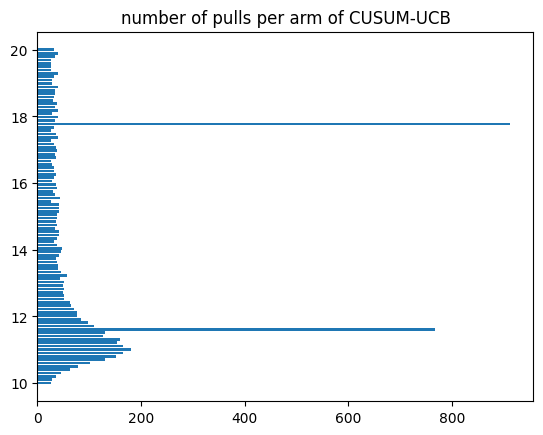

In [19]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.08)
plt.title('number of pulls per arm of CUSUM-UCB')
plt.show();

## Multiple products

In [16]:
# Utility function
def rescale(x, min_x, max_x):
    assert type(x) == np.ndarray or type(x) == list
    return [min_x + (max_x-min_x)*x_i for x_i in x]

In [44]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class MultiAgentGPUCBLearner():
    def __init__(self, T, discretization_1=100, discretization_2=100):
        self.T = T
        self.arms = np.array([
            np.linspace(0, 1, discretization_1),
            np.linspace(0, 1, discretization_2)
        ])
        assert len(self.arms) == 2
        kernel = RBF(1.0, (1e-3, 1e3))
        alpha = 1
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha ** 2, normalize_y=True, n_restarts_optimizer=9)
        self.a_t = None
        self.action_hist = [[], []]
        self.reward_hist = [[], []]
        
        self.confidence = [
            [np.inf] * discretization_1,
            [np.inf] * discretization_2
        ]
        self.empirical_means = [
            np.zeros(discretization_1),
            np.zeros(discretization_2)
        ]
        self.sigmas = [
            np.ones(discretization_1),
            np.ones(discretization_2)
        ]

    def pull_arm(self):
        upper_confidence_bound = [
            self.empirical_means[0] + self.sigmas[0],
            self.empirical_means[1] + self.sigmas[1]
        ]
        # Return where the confidence is maximum, for each of the two agents
        self.a_t = [
            np.argmax(upper_confidence_bound[0]),
            np.argmax(upper_confidence_bound[1])
        ]
        return [
            self.arms[0][self.a_t[0]],
            self.arms[1][self.a_t[1]]
        ]
    
    def update(self, r_t):
        self.action_hist[0].append(self.arms[0][self.a_t[0]])
        self.action_hist[1].append(self.arms[1][self.a_t[1]])
        self.reward_hist[0].append(r_t[0])
        self.reward_hist[1].append(r_t[1])
        
        self.gp.fit(np.array(self.action_hist).T, np.array(self.reward_hist).T)
        
        # for i in range(2):
        #     print(np.atleast_2d(self.arms[i]).T)
        #     self.empirical_means[i], self.sigmas[i] = self.gp.predict(np.atleast_2d(self.arms[i]).T, return_std=True)
        #     self.sigmas[i] = np.maximum(self.sigmas[i], 1e-2)
        self.empirical_means, self.sigmas = self.gp.predict(np.atleast_2d(np.array(self.arms)).T, return_std=True)

In [45]:
class MultiProductPricingEnvironment:
    def __init__(self, conversion_probability, costs):
        self.conversion_probability = conversion_probability
        self.costs = costs

    def round(self, p_t, n_t):
        assert type(p_t) == np.ndarray or type(p_t) == list
        assert len(p_t) == 2
        d_t = [np.random.binomial(n_t, self.conversion_probability[i](p_t[0], p_t[1])) for i in range(2)]
        r_t = [(p_t[i] - self.costs[i])*d_t[i] for i in range(2)]
        return d_t, r_t

In [50]:
# Parameters definition
max_price_1, min_price_1 = 50, 10
max_price_2, min_price_2 = 50, 20
min_price, max_price = min(min_price_1, min_price_2), max(max_price_1, max_price_2)
costs = [min_price_1, min_price_2]

T = 365
daily_customers = 100
K = 100 # discretization intervals

conversion_probabilities = [
    lambda p1, p2: 1-p1/max_price,  # linear demand curve
    lambda p1, p2: (p1/max_price)*(1-p2/max_price)
]

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 1000 different prices between 10 and 20

# let's compute the clairvoyant: it is the repetition for T times of the maximum daily profit
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    daily_rewards = np.array([])
    best_prices = np.array([])
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        daily_profit_curve = reward_function(prices, costs[i], daily_customers * conv_prob(prices, prices))
        best_price_index = np.argmax(daily_profit_curve)
        best_prices = np.append(best_prices, prices[best_price_index])
        daily_rewards = np.append(daily_rewards, daily_profit_curve[best_price_index])
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_rewards.sum())

In [51]:
from tqdm import tqdm

# Interaction between agent and environment
env = MultiProductPricingEnvironment(conversion_probabilities, costs)
agent = MultiAgentGPUCBLearner(T, discretization_1=K, discretization_2=K)

rewards = np.array([])
for t in tqdm(range(T)):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price) # p_t is a vector of 2 components (price for product 1 and price for product 2)
    d_t, r_t = env.round(p_t, n_t=daily_customers)
    agent.update([r_t[0] / daily_customers, r_t[1] / daily_customers])
    rewards = np.append(rewards, np.array(r_t).sum())

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-rewards)

100%|██████████| 365/365 [01:03<00:00,  5.75it/s]


In [52]:
for i in range(2):
    prices = rescale(agent.action_hist[i], min_price, max_price)
    profits = agent.reward_hist[i]
    gp = RBFGaussianProcess(scale=2)
    gp.fit(prices, profits)
    mu, sigma = gp.predict(np.linspace(min_price, max_price, K))
    plt.scatter(prices, profits, label='Samples', color='C1')
    plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
    plt.axvline(best_prices[i], color='red',label='Optimal Price')
    plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
    plt.title('GPUCB - Final estimated profit curve (normalized)')
    plt.xlabel('Price')
    plt.legend()
    plt.show();

TypeError: unsupported operand type(s) for +: 'int' and 'list'

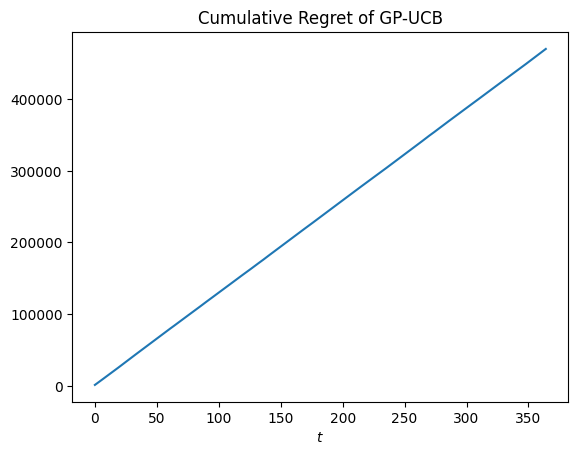

In [54]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();